TensorFlow version: 2.19.0
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Train shape: (60000, 784)
Test  shape: (10000, 784)
Final Train: (50000, 784), Validation: (10000, 784), Test: (10000, 784)

Training Model A (seed=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
391/391 - 8s - 20ms/step - accuracy: 0.7683 - loss: 0.6508 - val_accuracy: 0.8445 - val_loss: 0.4286
Epoch 2/15
391/391 - 1s - 4ms/step - accuracy: 0.8393 - loss: 0.4479 - val_accuracy: 0.8633 - val_loss: 0.3746
Epoch 3/15
391/391 - 1s - 3ms/step - accuracy: 0.8537 - loss: 0.4021 - val_accuracy: 0.8712 - val_loss: 0.3497
Epoch 4/15
391/391 - 1s - 3ms/step - accuracy: 0.8650 - loss: 0.3759 - val_accuracy: 0.8736 - val_loss: 0.3446
Epoch 5/15
391/391 - 1s - 3ms/step - accuracy: 0.8699 - loss: 0.3561 - val_accuracy: 0.8805 - val_loss: 0.3274
Epoch 6/15
391/391 - 1s - 3ms/step - accuracy: 0.8748 - loss: 0.3440 - val_accuracy: 0.8806 - val_loss: 0.3238
Epoch 7/15
391/391 - 1s - 3ms/step - accuracy: 0.8779 - loss: 0.3322 - val_accuracy: 0.8844 - val_loss: 0.3132
Epoch 8/15
391/391 - 1s - 3ms/step - accuracy: 0.8809 - loss: 0.3211 - val_accuracy: 0.8865 - val_loss: 0.3142
Epoch 9/15
391/391 - 1s - 3ms/step - accuracy: 0.8825 - loss: 0.3180 - val_accuracy: 0.8869 - val_loss: 0.3122


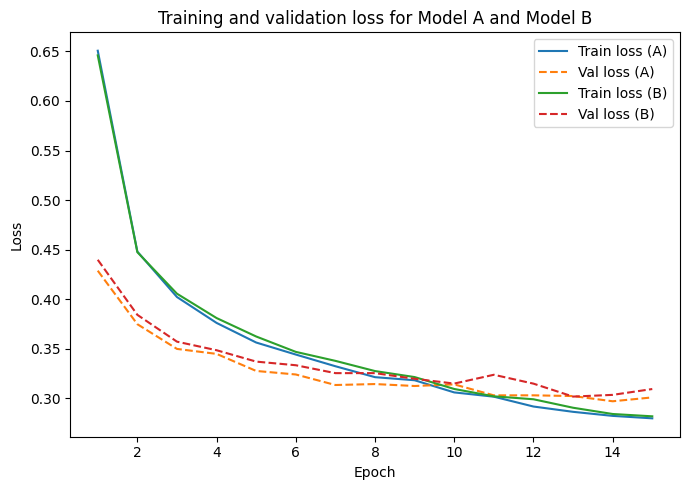

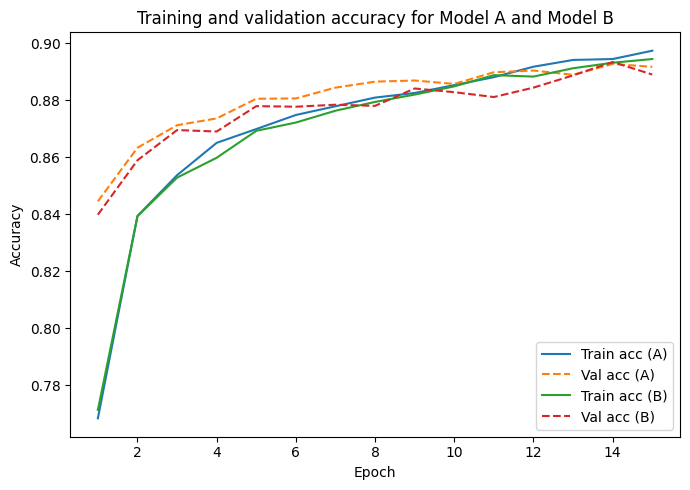


Evaluating sensitivity to Gaussian noise...


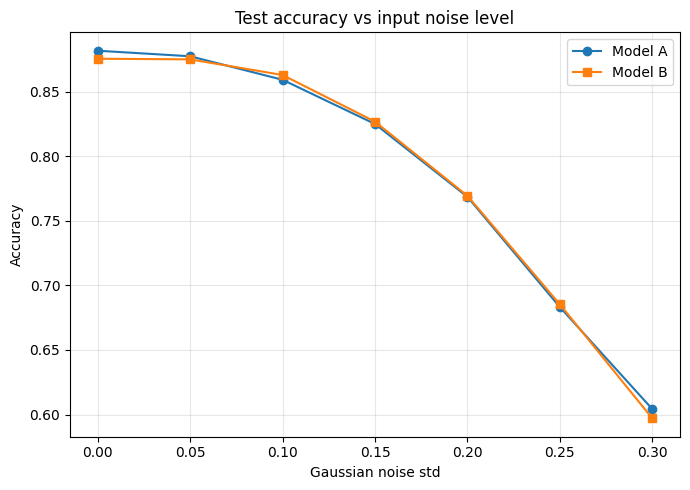

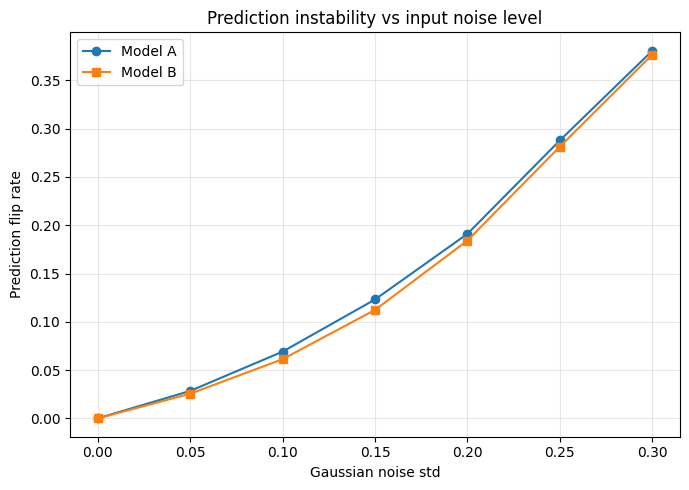

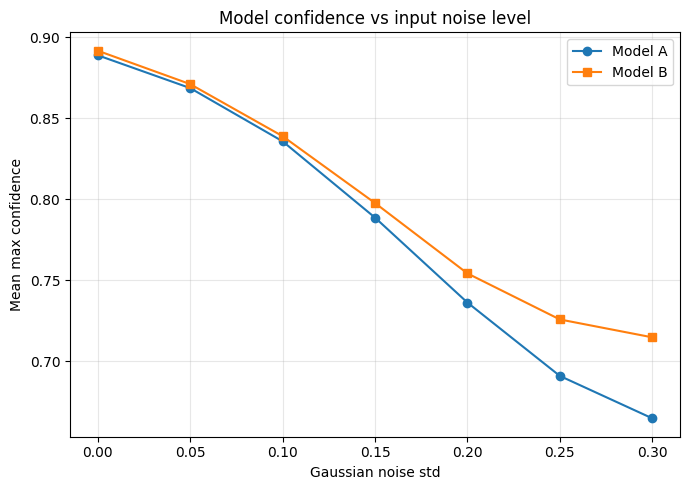


=== SENSITIVITY SUMMARY (Test set, varying noise) ===
Noise std |  Acc_A |  Acc_B |  Flip_A |  Flip_B |  Conf_A |  Conf_B
----------------------------------------------------------------------
     0.00 |  0.882 |  0.875 |   0.000 |   0.000 |   0.889 |   0.892
     0.05 |  0.877 |  0.875 |   0.028 |   0.025 |   0.868 |   0.871
     0.10 |  0.859 |  0.863 |   0.069 |   0.061 |   0.836 |   0.839
     0.15 |  0.825 |  0.827 |   0.123 |   0.112 |   0.789 |   0.798
     0.20 |  0.768 |  0.769 |   0.191 |   0.184 |   0.736 |   0.754
     0.25 |  0.683 |  0.685 |   0.288 |   0.281 |   0.691 |   0.726
     0.30 |  0.604 |  0.597 |   0.381 |   0.377 |   0.665 |   0.715

Saved figures:
 - figures_sensitivity/loss_curves_models.png
 - figures_sensitivity/accuracy_curves_models.png
 - figures_sensitivity/accuracy_vs_noise.png
 - figures_sensitivity/fliprate_vs_noise.png
 - figures_sensitivity/confidence_vs_noise.png


In [1]:
# ============================================================
# Sensitivity of "Equivalent" Neural Networks to Input Perturbations
# Two models with same architecture but different seeds
# Evaluated under increasing Gaussian noise on Fashion-MNIST
# ============================================================

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# ------------------------------------------------------------------
# 1. Global setup
# ------------------------------------------------------------------
os.makedirs("figures_sensitivity", exist_ok=True)
print("TensorFlow version:", tf.__version__)

# For reproducibility (base seed)
BASE_SEED = 123

def set_global_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

# ------------------------------------------------------------------
# 2. Load and preprocess Fashion-MNIST
# ------------------------------------------------------------------
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# Normalise to [0,1] and flatten
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
x_train = x_train.reshape((x_train.shape[0], -1))
x_test  = x_test.reshape((x_test.shape[0], -1))

num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test,  num_classes)

print("Train shape:", x_train.shape)
print("Test  shape:", x_test.shape)

# Split out a validation set from training data
VAL_SIZE = 10000
x_val, x_train_sub = x_train[:VAL_SIZE], x_train[VAL_SIZE:]
y_val, y_train_sub = y_train_cat[:VAL_SIZE], y_train_cat[VAL_SIZE:]

print(f"Final Train: {x_train_sub.shape}, Validation: {x_val.shape}, Test: {x_test.shape}")

# ------------------------------------------------------------------
# 3. Model builder (same architecture, different initialisation via seed)
# ------------------------------------------------------------------
def build_model(seed):
    set_global_seed(seed)
    model = Sequential([
        Dense(256, activation="relu", input_shape=(784,)),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ------------------------------------------------------------------
# 4. Train two "equivalent" models with different seeds
# ------------------------------------------------------------------
EPOCHS = 15
BATCH_SIZE = 128

print("\n==============================")
print("Training Model A (seed=1)")
print("==============================")
model_a = build_model(seed=1)
history_a = model_a.fit(
    x_train_sub, y_train_sub,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)

print("\n==============================")
print("Training Model B (seed=2)")
print("==============================")
model_b = build_model(seed=2)
history_b = model_b.fit(
    x_train_sub, y_train_sub,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)

# Final clean test evaluations
test_loss_a, test_acc_a = model_a.evaluate(x_test, y_test_cat, verbose=0)
test_loss_b, test_acc_b = model_b.evaluate(x_test, y_test_cat, verbose=0)

print("\n=== FINAL CLEAN TEST PERFORMANCE ===")
print(f"Model A - Test accuracy: {test_acc_a:.4f}, Test loss: {test_loss_a:.4f}")
print(f"Model B - Test accuracy: {test_acc_b:.4f}, Test loss: {test_loss_b:.4f}")

# ------------------------------------------------------------------
# 5. Plot training & validation curves (loss and accuracy)
# ------------------------------------------------------------------
epochs_range = range(1, EPOCHS + 1)

# Loss curves
plt.figure(figsize=(7,5))
plt.plot(epochs_range, history_a.history["loss"], label="Train loss (A)")
plt.plot(epochs_range, history_a.history["val_loss"], label="Val loss (A)", linestyle="--")
plt.plot(epochs_range, history_b.history["loss"], label="Train loss (B)")
plt.plot(epochs_range, history_b.history["val_loss"], label="Val loss (B)", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss for Model A and Model B")
plt.legend()
plt.tight_layout()
plt.savefig("figures_sensitivity/loss_curves_models.png", dpi=300)
plt.show()

# Accuracy curves
plt.figure(figsize=(7,5))
plt.plot(epochs_range, history_a.history["accuracy"], label="Train acc (A)")
plt.plot(epochs_range, history_a.history["val_accuracy"], label="Val acc (A)", linestyle="--")
plt.plot(epochs_range, history_b.history["accuracy"], label="Train acc (B)")
plt.plot(epochs_range, history_b.history["val_accuracy"], label="Val acc (B)", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy for Model A and Model B")
plt.legend()
plt.tight_layout()
plt.savefig("figures_sensitivity/accuracy_curves_models.png", dpi=300)
plt.show()

# ------------------------------------------------------------------
# 6. Define perturbations and evaluation helpers
# ------------------------------------------------------------------
def add_gaussian_noise(x, std):
    noise = np.random.normal(loc=0.0, scale=std, size=x.shape).astype("float32")
    x_noisy = x + noise
    # Clip back to [0,1]
    x_noisy = np.clip(x_noisy, 0.0, 1.0)
    return x_noisy

def evaluate_model_under_noise(model, x_clean, y_true_cat, noise_stds):
    """
    Returns:
        acc_list: accuracy for each noise level
        conf_list: mean max softmax confidence for each noise level
        flip_rates: fraction of samples whose prediction differs from clean prediction
    """
    # Clean predictions for baseline
    clean_probs = model.predict(x_clean, batch_size=256, verbose=0)
    clean_preds = np.argmax(clean_probs, axis=1)
    y_true = np.argmax(y_true_cat, axis=1)

    acc_list = []
    conf_list = []
    flip_rates = []

    for std in noise_stds:
        if std == 0.0:
            x_eval = x_clean
        else:
            x_eval = add_gaussian_noise(x_clean, std)

        probs = model.predict(x_eval, batch_size=256, verbose=0)
        preds = np.argmax(probs, axis=1)
        max_conf = np.max(probs, axis=1)

        acc = np.mean(preds == y_true)
        mean_conf = np.mean(max_conf)
        flip_rate = np.mean(preds != clean_preds)

        acc_list.append(acc)
        conf_list.append(mean_conf)
        flip_rates.append(flip_rate)

    return acc_list, conf_list, flip_rates

# ------------------------------------------------------------------
# 7. Run robustness evaluation across noise levels
# ------------------------------------------------------------------
noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

print("\nEvaluating sensitivity to Gaussian noise...")
acc_a, conf_a, flips_a = evaluate_model_under_noise(model_a, x_test, y_test_cat, noise_levels)
acc_b, conf_b, flips_b = evaluate_model_under_noise(model_b, x_test, y_test_cat, noise_levels)

# ------------------------------------------------------------------
# 8. Plot robustness metrics vs noise level
# ------------------------------------------------------------------

# Accuracy vs noise
plt.figure(figsize=(7,5))
plt.plot(noise_levels, acc_a, marker="o", label="Model A")
plt.plot(noise_levels, acc_b, marker="s", label="Model B")
plt.xlabel("Gaussian noise std")
plt.ylabel("Accuracy")
plt.title("Test accuracy vs input noise level")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures_sensitivity/accuracy_vs_noise.png", dpi=300)
plt.show()

# Flip rate vs noise
plt.figure(figsize=(7,5))
plt.plot(noise_levels, flips_a, marker="o", label="Model A")
plt.plot(noise_levels, flips_b, marker="s", label="Model B")
plt.xlabel("Gaussian noise std")
plt.ylabel("Prediction flip rate")
plt.title("Prediction instability vs input noise level")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures_sensitivity/fliprate_vs_noise.png", dpi=300)
plt.show()

# Confidence vs noise
plt.figure(figsize=(7,5))
plt.plot(noise_levels, conf_a, marker="o", label="Model A")
plt.plot(noise_levels, conf_b, marker="s", label="Model B")
plt.xlabel("Gaussian noise std")
plt.ylabel("Mean max confidence")
plt.title("Model confidence vs input noise level")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures_sensitivity/confidence_vs_noise.png", dpi=300)
plt.show()

# ------------------------------------------------------------------
# 9. Print summary table
# ------------------------------------------------------------------
print("\n=== SENSITIVITY SUMMARY (Test set, varying noise) ===")
print(f"{'Noise std':>9} | {'Acc_A':>6} | {'Acc_B':>6} | {'Flip_A':>7} | {'Flip_B':>7} | {'Conf_A':>7} | {'Conf_B':>7}")
print("-" * 70)
for i, std in enumerate(noise_levels):
    print(f"{std:9.2f} | {acc_a[i]:6.3f} | {acc_b[i]:6.3f} | {flips_a[i]:7.3f} | {flips_b[i]:7.3f} | {conf_a[i]:7.3f} | {conf_b[i]:7.3f}")

print("\nSaved figures:")
print(" - figures_sensitivity/loss_curves_models.png")
print(" - figures_sensitivity/accuracy_curves_models.png")
print(" - figures_sensitivity/accuracy_vs_noise.png")
print(" - figures_sensitivity/fliprate_vs_noise.png")
print(" - figures_sensitivity/confidence_vs_noise.png")
